# Life history traits model  20 & 21  

Taylor Chapter 3  
model to describe age-structured life history traits of understudied Carcharhinid species

Model versions: both fixed effects. same covariates as model 17.  testing 2 fixed effects versions to see if the priors were specified wrong in the previous version.  Maybe a bad idea to allow a50 to vary on a uniform prior? makes more sense if is normal, as coming form a biological population

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

,Species,Stock,Stock_Year,Age,maturity,survivorship,fecundity (num female pups per year),notes,model type,source_mat,...,linf_cm,growth_coeff_k,lmax_cm,age_max_yrs,temp_pref,nursery,depth_min,depth_max,depth_ave,param_complete
0,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,0,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
1,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,1,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
2,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,2,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
3,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,3,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
4,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,4,0.016088,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0


In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [6]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(485, 37)

In [7]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])


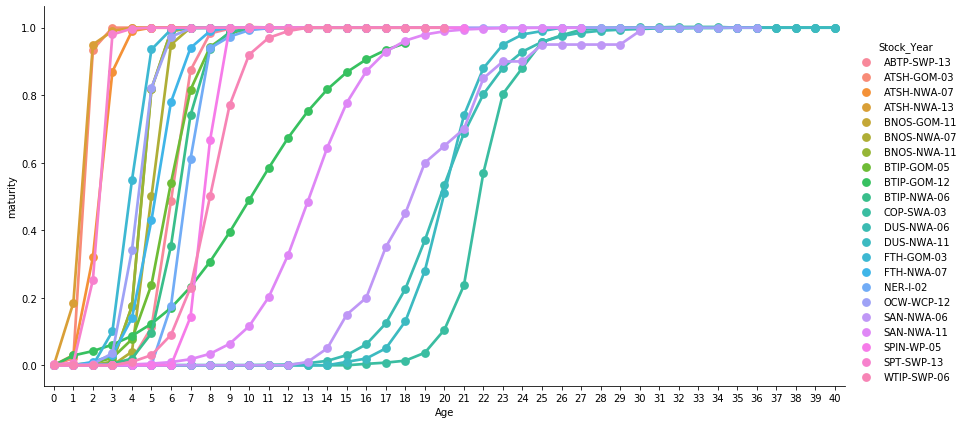

In [8]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [9]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [10]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [11]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [12]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Model Specification

In [13]:
# fixed effects model with stripped out S
#run with same priors as 17
# model 20
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
   # β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    # β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    β12 = pm.Normal('Temperature', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
   # S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
   # S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # now put all the priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [14]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2165 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


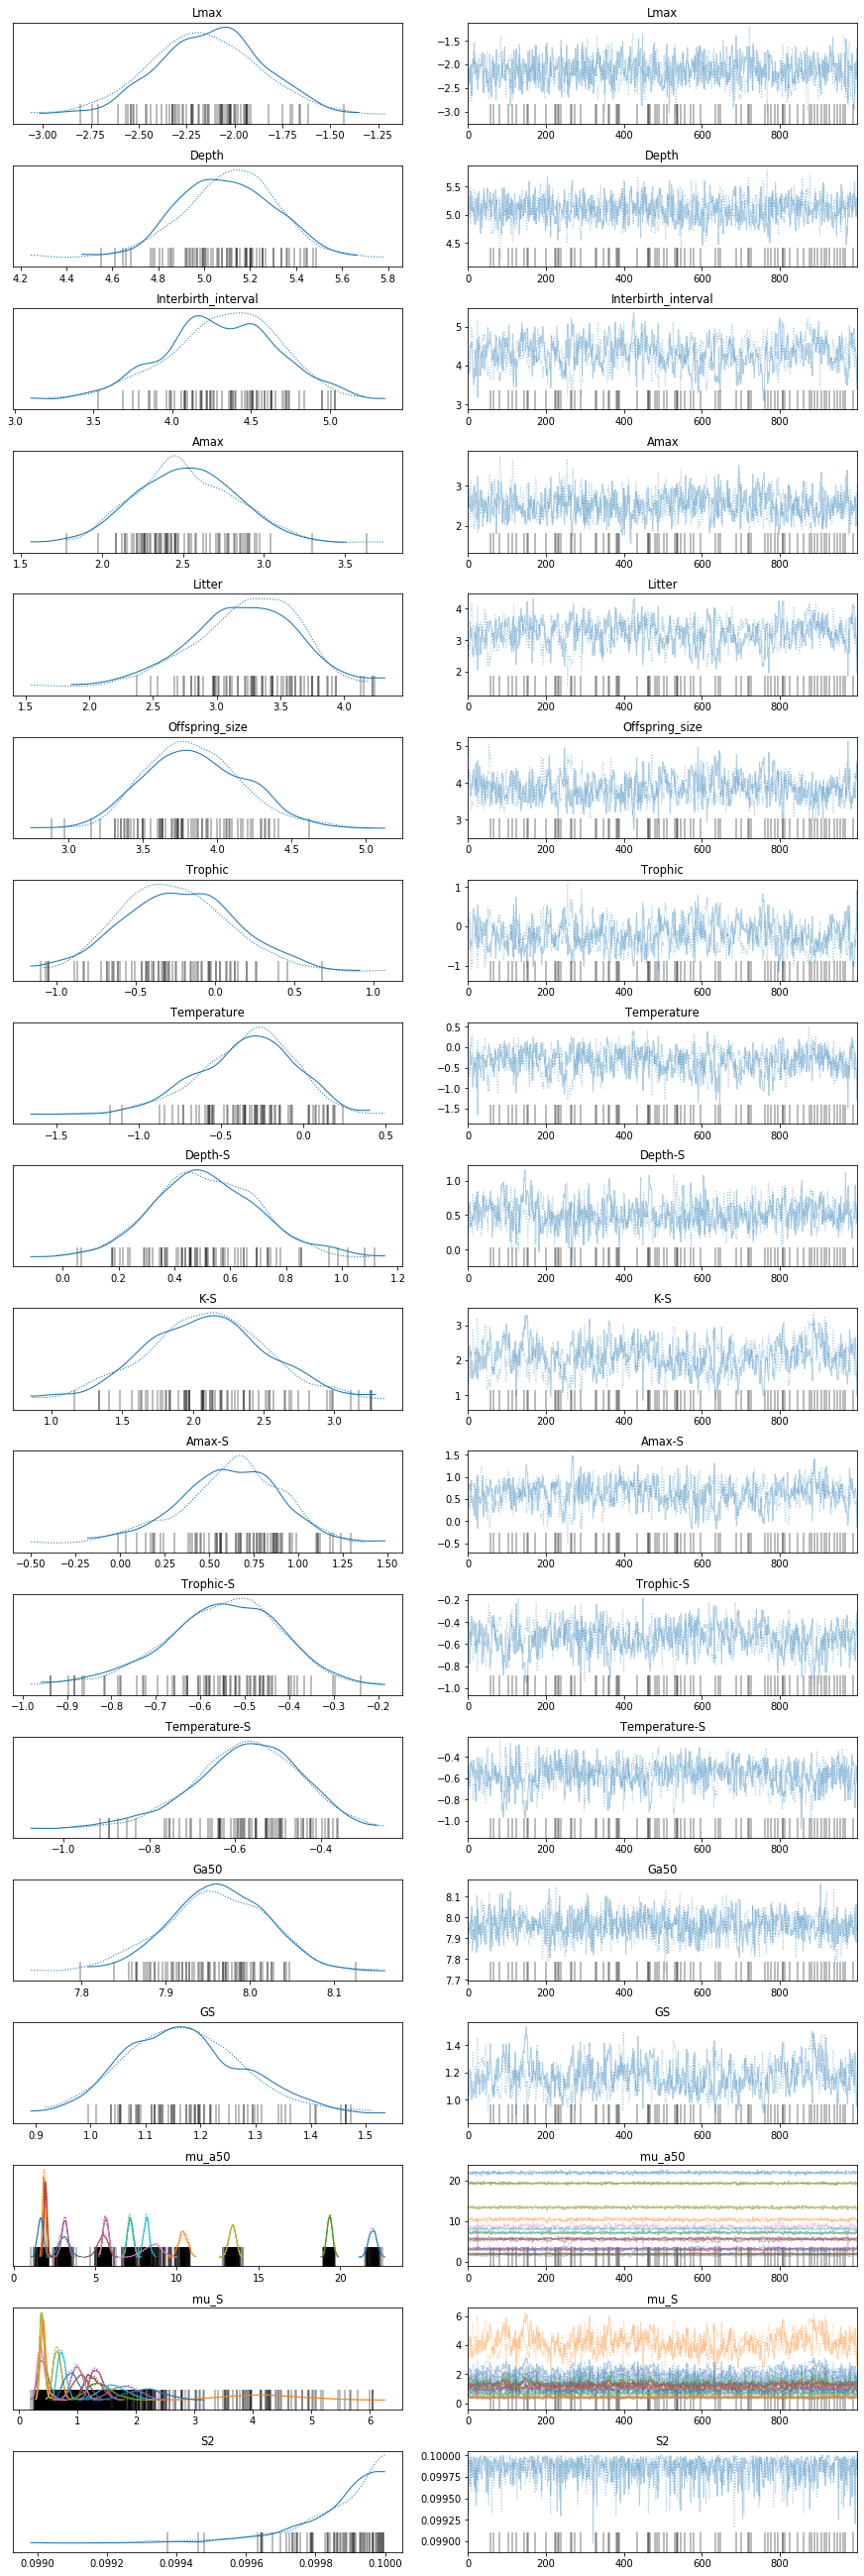

In [15]:
#check model performance
pm.traceplot(trace1);

In [17]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Lmax,-2.144,0.281,-2.634,-1.594,0.010,0.007,742.0,729.0,745.0,740.0,1.01
Depth,5.104,0.208,4.716,5.472,0.009,0.006,584.0,584.0,595.0,787.0,1.01
Interbirth_interval,4.314,0.363,3.604,4.963,0.026,0.019,190.0,190.0,205.0,430.0,1.02
Amax,2.525,0.312,1.978,3.116,0.016,0.012,364.0,363.0,367.0,842.0,1.01
Litter,3.228,0.410,2.451,3.980,0.026,0.018,253.0,253.0,256.0,388.0,1.01
Offspring_size,3.851,0.339,3.208,4.460,0.017,0.012,391.0,384.0,401.0,431.0,1.01
Trophic,-0.237,0.348,-0.903,0.402,0.022,0.016,248.0,248.0,251.0,466.0,1.02
Temperature,-0.348,0.297,-0.924,0.172,0.017,0.012,304.0,304.0,313.0,390.0,1.01
Depth-S,0.514,0.187,0.166,0.864,0.009,0.007,405.0,379.0,412.0,604.0,1.00
K-S,2.095,0.428,1.306,2.930,0.032,0.023,178.0,178.0,179.0,300.0,1.02


In [19]:
# fixed effects model with stripped out S
#run with new priors
# model 21
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Normal('Ga50', 10, 10) #mean a50 has uniform distribution with a mean of 10 and a std dev of 10
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
   # β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    # β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    β12 = pm.Normal('Temperature', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Exponential('GS', 1) # Exponential distribution starting at 1 (1 is most likely value, no values <1)
    
    # now put all the priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [20]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2925 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


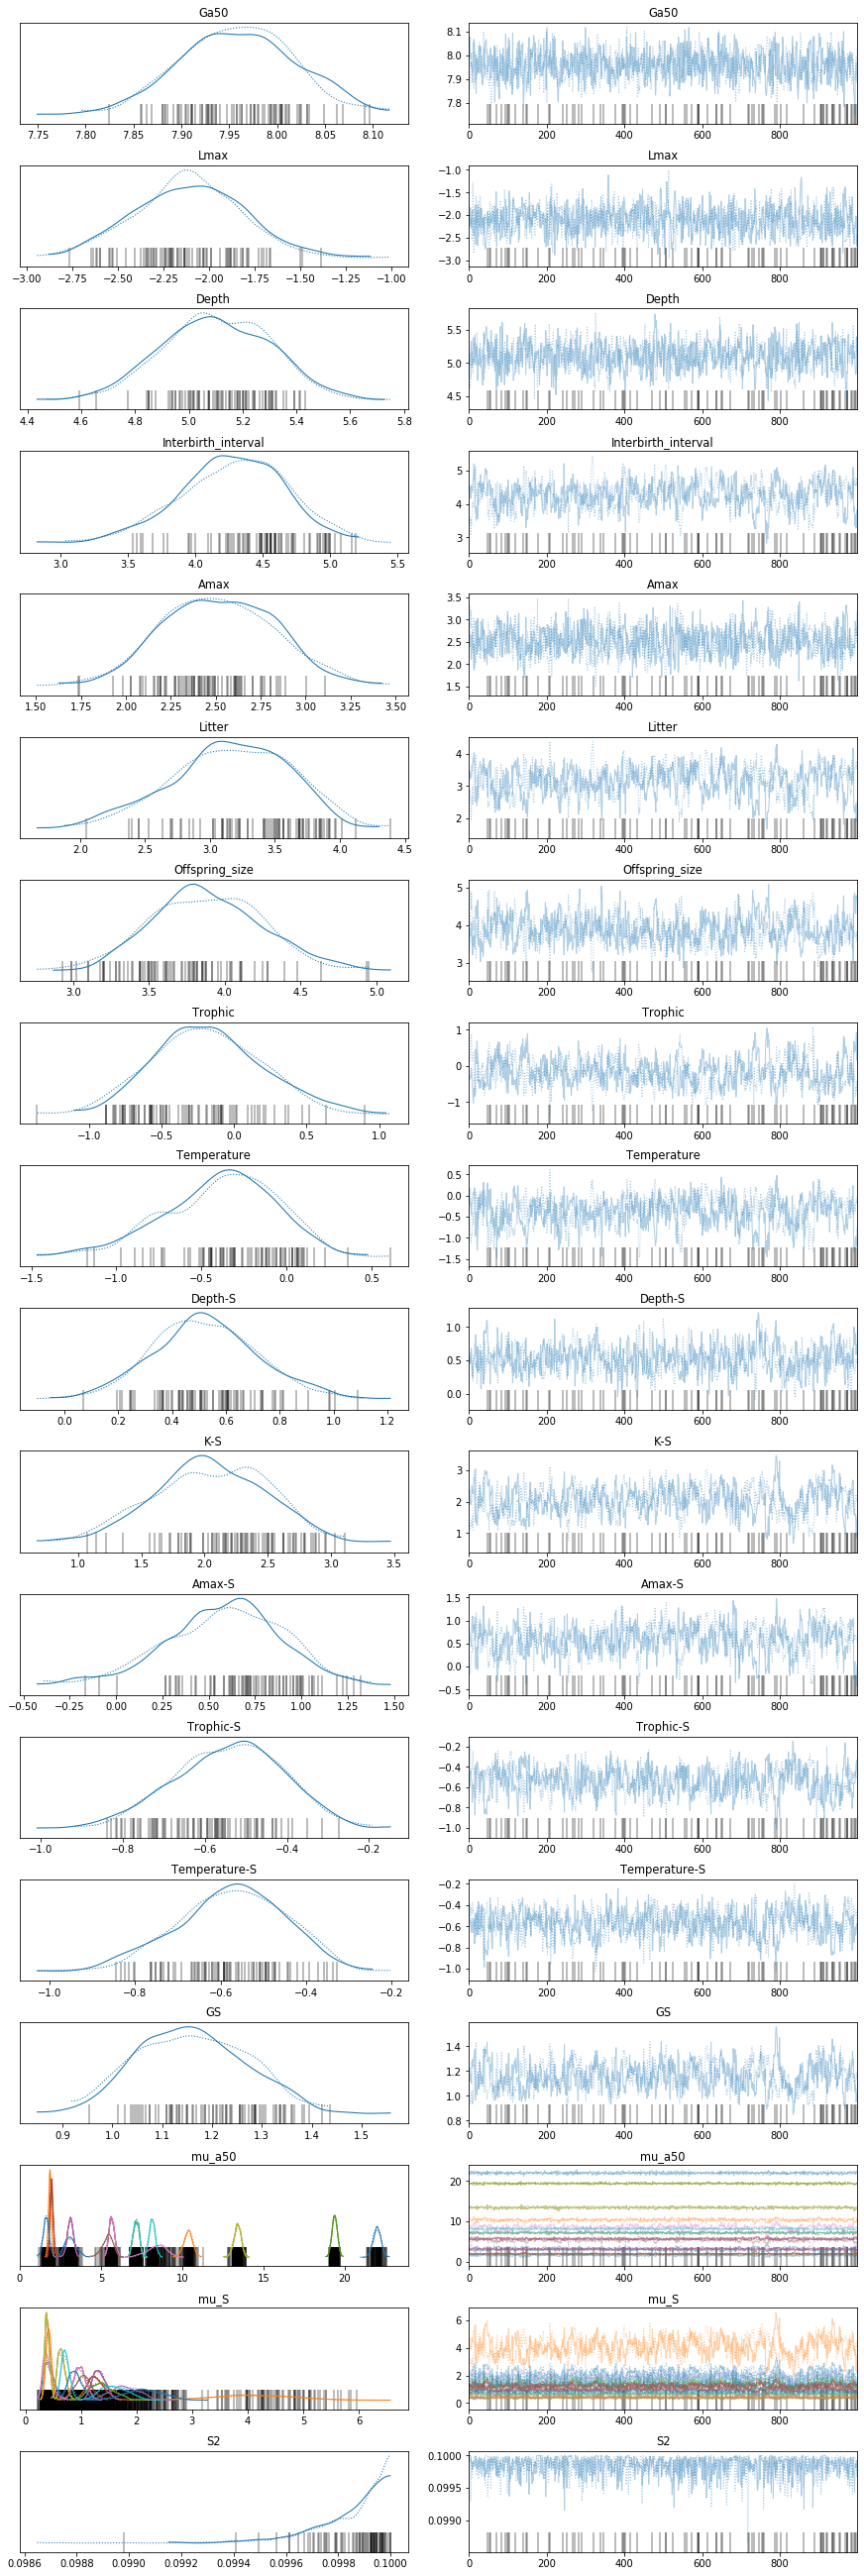

In [22]:
#check model performance
pm.traceplot(trace2);

In [23]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Ga50,7.959,0.059,7.852,8.071,0.002,0.001,817.0,816.0,820.0,1092.0,1.00
Lmax,-2.113,0.292,-2.660,-1.565,0.010,0.007,947.0,947.0,954.0,1077.0,1.00
Depth,5.103,0.201,4.746,5.485,0.007,0.005,747.0,747.0,746.0,990.0,1.00
Interbirth_interval,4.273,0.395,3.529,5.019,0.027,0.019,208.0,207.0,209.0,427.0,1.00
Amax,2.517,0.313,1.919,3.072,0.014,0.010,531.0,531.0,537.0,848.0,1.00
Litter,3.158,0.452,2.326,3.990,0.033,0.023,187.0,186.0,190.0,472.0,1.01
Offspring_size,3.885,0.373,3.175,4.561,0.024,0.017,240.0,240.0,241.0,583.0,1.00
Trophic,-0.180,0.375,-0.837,0.545,0.026,0.018,212.0,212.0,213.0,400.0,1.01
Temperature,-0.388,0.335,-1.013,0.194,0.023,0.016,208.0,208.0,211.0,462.0,1.00
Depth-S,0.524,0.202,0.158,0.928,0.010,0.007,426.0,390.0,434.0,506.0,1.00


In [24]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

'.pymc_14.trace'

In [25]:
pm.save_trace(trace2)

'.pymc_15.trace'

### Model Results

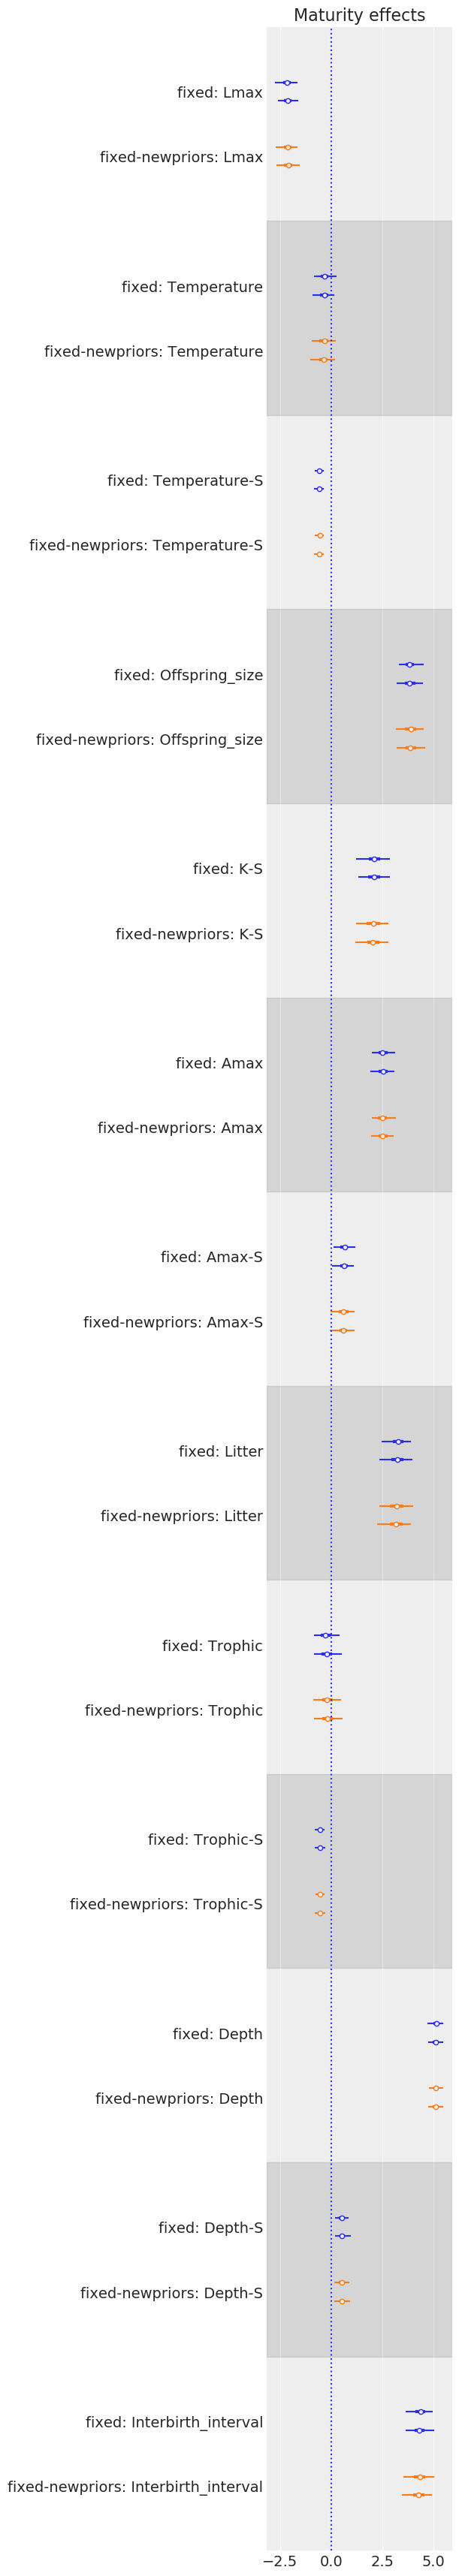

<Figure size 720x480 with 0 Axes>

In [27]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["fixed", "fixed-newpriors"], var_names=["Lmax", "Temperature", "Temperature-S", "Offspring_size", "K-S", "Amax", "Amax-S", "Litter", "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat20&21_forest.jpg');

### Model Comparison

In [28]:
#WAIC for model 1 (20)
pm.waic(trace1, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic     0.44   160.81
p_waic          179.69        -

There has been a warning during the calculation. Please check the results.

In [29]:
#WAIC for model 2 (21)
pm.waic(trace2, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic    35.17   165.25
p_waic          201.33        -

There has been a warning during the calculation. Please check the results.

Model 20 WAIC = 0.44
Model 21 WAIC = 35

model 20 (original priors) preferred over model 21

#### Look for 'bad' datapoints

In [30]:
loo1 = pm.loo(trace1, mat1)
loo1

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo    -3.85    80.99
p_loo      183.33        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      433   89.3%
 (0.5, 0.7]   (ok)         29    6.0%
   (0.7, 1]   (bad)        15    3.1%
   (1, Inf)   (very bad)    8    1.6%

In [31]:
loo2 = pm.loo(trace2, mat2)
loo2

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo   -12.90    81.79
p_loo      196.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      423   87.2%
 (0.5, 0.7]   (ok)         35    7.2%
   (0.7, 1]   (bad)        16    3.3%
   (1, Inf)   (very bad)   11    2.3%

In [32]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]

In [33]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [34]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat20_model_results.csv')
result1.head()

# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat21_model_results.csv')

In [35]:
#Grab data from mat1 (model 20 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [36]:
#Grab data from mat2 (model 21 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T


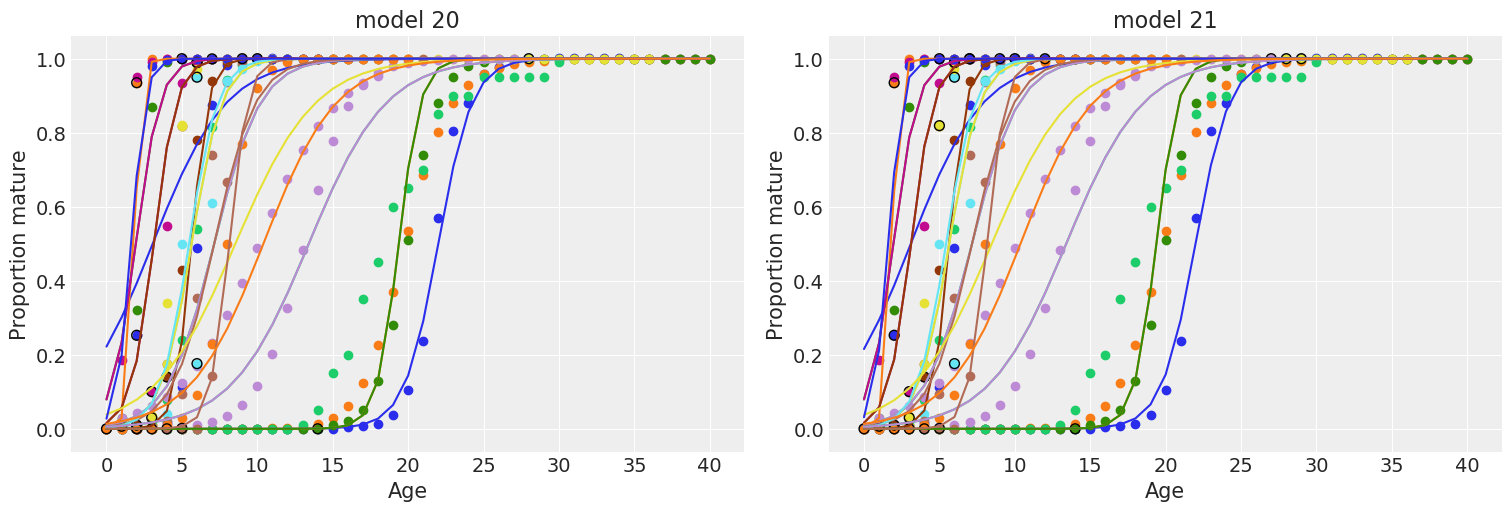

In [38]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('model 20')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('model 21')

#save results
plt.savefig('mat20_mat21_modelfit.jpg',dpi=300);

Text(0, 0.5, 'Proportion mature')

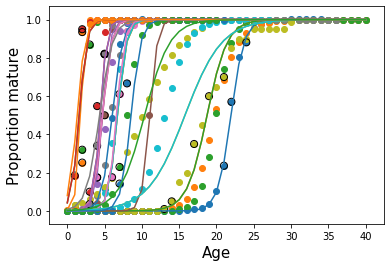

In [112]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
# plot bad datapoints
plt.scatter(badpoints3.Age, badpoints3.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)